In [1]:
import os
if os.getcwd().endswith('notebooks'):
    os.chdir(os.path.join(os.getcwd(), os.pardir))
os.getcwd()

'D:\\python\\modelling-ncov2019'

In [2]:
import pandas as pd
import numpy as np
import networkx as nx

In [3]:
from src.features import entities

In [22]:
gender_df = pd.DataFrame(data={'gender': [entities.Gender.FEMALE, entities.Gender.MALE], 'prob': [114/214, 100/214]})   

In [23]:
gender_df

,gender,prob
0,Gender.FEMALE,0.53271
1,Gender.MALE,0.46729


In [42]:
data_folder = os.path.join(os.getcwd(), 'data', 'processed')

# Age and Gender

Assumption: given a 5 year bucket assume each age within this bucket is equally likely

In [45]:
age_gender_df = pd.read_excel(os.path.join(data_folder, 'age_gender.xlsx'), sheet_name='processed')
age_gender_df.head()

,Age,Total,Males,Females
0,0,7215,3698,3517
1,1,7474,3821,3653
2,2,7319,3748,3571
3,3,6974,3596,3378
4,4,6663,3469,3194


In [46]:
age_gender_df['age_probability'] = age_gender_df.Total / age_gender_df.Total.sum()

In [47]:
age_gender_df['female_probability'] = age_gender_df.Females / (age_gender_df.Females + age_gender_df.Males)

In [48]:
age_gender_df.head()

,Age,Total,Males,Females,age_probability,female_probability
0,0,7215,3698,3517,0.011245,0.487457
1,1,7474,3821,3653,0.011649,0.488761
2,2,7319,3748,3571,0.011407,0.487908
3,3,6974,3596,3378,0.010869,0.484371
4,4,6663,3469,3194,0.010385,0.479364


In [49]:
def sample_age_gender(age_gender_df):
    index = np.random.choice(age_gender_df.index.tolist(), p=age_gender_df.age_probability)
    row = age_gender_df.iloc[index]
    age = row.Age
    genders = [entities.Gender.FEMALE, entities.Gender.MALE]
    gender = genders[np.random.choice([0, 1], p=[row.female_probability, 1-row.female_probability])]
    return age, gender

In [62]:
infected = entities.Node(1)
infected.age, infected.gender = sample_age_gender(age_gender_df)

In [63]:
infected

{'idx': 1,
 'age': 38.0,
 'gender': 0,
 'employment_status': -1,
 'social_competence': -1,
 'public_transport_usage': -1,
 'public_transport_duration': -1,
 'household_index': -1,
 'profession': -1}

# Household structure

| Obszar                 | Ogółem  | Małżeństwa razem | Małżeństwa bez dzieci | Małżeństwa z dziećmi | Partnerzy razem | Partnerzy bez dzieci | Partnerzy z dziećmi | Matki z dziećmi | Ojcowie z dziećmi |
|------------------------|---------|------------------|-----------------------|----------------------|-----------------|----------------------|---------------------|-----------------|-------------------|
| Powiat miasto Wrocław  | 175640  | 126831           | 43884                 | 82947                | 6346            | 3697                 | 2649                | 37223           | 5240              |
| Wrocław-Fabryczna      | 56093   | 42033            | 13771                 | 28262                | 1618            | 966                  | 652                 | 10908           | 1534              |
| Wrocław-Krzyki         | 45769   | 33202            | 11955                 | 21247                | 1656            | 990                  | 666                 | 9580            | 1331              |
| Wrocław-Psie Pole      | 25126   | 18950            | 6077                  | 12873                | 815             | 436                  | 379                 | 4660            | 701               |
| Wrocław-Stare Miasto   | 16184   | 10866            | 4810                  | 6056                 | 709             | 464                  | 245                 | 4055            | 554               |

źródło: https://wroclaw.stat.gov.pl/cps/rde/xbcr/wroc/ASSETS_gospodarstwa_tablice.xls

In [4]:
nb_of_people = [1,2,3,4,5]
nb_of_households = [92713,81495,51620,31719,15434]
households = pd.DataFrame(data={'nb_of_people_in_household': nb_of_people, 'nb_of_households': nb_of_households})

In [5]:
households['nb_of_people'] = households.nb_of_people_in_household * households.nb_of_households

In [6]:
households['probability'] = households.nb_of_people / households.nb_of_people.sum()

In [7]:
households

,nb_of_people_in_household,nb_of_households,nb_of_people,probability
0,1,92713,92713,0.150849
1,2,81495,162990,0.265193
2,3,51620,154860,0.251965
3,4,31719,126876,0.206434
4,5,15434,77170,0.125560


In [8]:
def sample_household_headcount(households):
    return np.random.choice(households.nb_of_people_in_household, p=households.probability)

In [9]:
where_do_they_live = sample_household_headcount(households)

In [10]:
where_do_they_live

3

In [11]:
G = nx.Graph()
infected = entities.Node(1)
entities.add_node(G, infected)

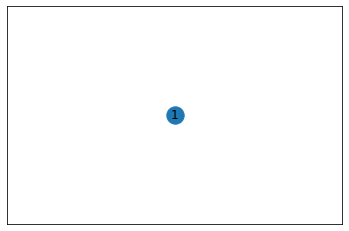

In [12]:
nx.draw_networkx(G)

In [15]:
for i in range(1, where_do_they_live):
    cohabitant = entities.Node(infected.idx + i)
    entities.add_node(G, cohabitant)
    G.add_edge(infected.idx, cohabitant.idx)

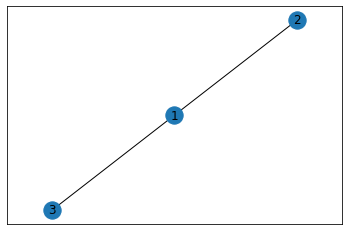

In [17]:
nx.draw_networkx(G)

# Who these cohabitants might be?

| Infected, Headcount       | A1 | A2 | C2 | A3   | C3   | A4      | C4      | A5         | C5         |
|---------------------------|----|----|----|------|------|---------|---------|------------|------------|
| Cohabitants               | -  | C  | A  | A, A | A, A | A, A, A | A, A, A | A, A, A, A | A, A, A, A |
| -                         | -  | A  | -  | A, C | A, C | A, A, C | A, A, C | A, A, A, C | A, A, A, C |
| -                         | -  | -  | -  | C, C | -    | A, C, C | A, C, C | A, A, C, C | A, A, C, C |
| -                         | -  | -  | -  | -    | -    | C, C, C | -       | A, C, C, C | A, C, C, C |
| -                         | -  | -  | -  | -    | -    | -       | -       | C, C, C, C | -          |